## From the paper: 
Golub et al "Molecular Classification of Cancer: Class Discovery and Class
Prediction by Gene Expression Monitoring"

Our initial leukemia dataset consists of 38 bone marrow samples collected from patients diagnosed with acute leukemia - 27 with Acute Lymphoblastic Leukemia (ALL) and 11 with Acute Myeloid Leukemia (AML), as described in the original publication.

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import plotly.express as px
# !pip install kagglehub
import kagglehub

In [2]:

# Download dataset
path = kagglehub.dataset_download("crawford/gene-expression")

print("Path to dataset files:", path)

Path to dataset files: /home/beatriz/.cache/kagglehub/datasets/crawford/gene-expression/versions/3


In [3]:
gene_expression_test = pd.read_csv(path + "/data_set_ALL_AML_independent.csv")

print(gene_expression_test.shape) 

gene_expression_test.head()

(7129, 70)


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [4]:
gene_expression_train = pd.read_csv(path + "/data_set_ALL_AML_train.csv")

print(gene_expression_train.shape) 
gene_expression_train.head()

(7129, 78)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [5]:
metadata = pd.read_csv(path + "/actual.csv")

print(metadata["cancer"].value_counts())

metadata.head()

ALL    47
AML    25
Name: cancer, dtype: int64


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


## Note on the 'call' Columns
Since no documentation is provided for the 'call' columns, we removed them. However, this may not be the most robust approach. Additionally, the column ordering is not strictly numerical, which should be kept in mind during preprocessing.

In [6]:
df1 = [col for col in gene_expression_train.columns if "call" not in col]
X_train = gene_expression_train[df1]
X_train.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


In [7]:
# Converter de string para int e ordenar
sorted_train_columns = sorted([int(col) for col in X_train.columns[2:]])

sorted_train_columns = [str(col) for col in sorted_train_columns]

X_train = X_train[["Gene Description", "Gene Accession Number"] + sorted_train_columns]
X_train.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,15,-318,-32,-124,-135,-20,7,-213,-25,-72
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-114,-192,-49,-79,-186,-207,-100,-252,-20,-139
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,2,-95,49,-37,-70,-50,-57,136,124,-1
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,193,312,230,330,337,101,132,318,325,392
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-51,-139,-367,-188,-407,-369,-377,-209,-396,-324


In [8]:
df2 = [col for col in gene_expression_test.columns if "call" not in col]

X_test = gene_expression_test[df2]
sorted_test_columns = sorted([int(col) for col in X_test.columns[2:]])

sorted_test_columns = [str(col) for col in sorted_test_columns]

X_test[["Gene Description", "Gene Accession Number"] + sorted_test_columns]
X_test.head()

,Gene Description,Gene Accession Number,39,40,42,47,48,49,41,43,...,54,57,58,60,61,65,66,63,64,62
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,-87,22,-243,-130,-256,-62,86,...,-90,-137,-157,-172,-47,-62,-58,-161,-48,-176
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,-248,-153,-218,-177,-249,-23,-36,...,-87,-51,-370,-122,-442,-198,-217,-215,-531,-284
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,262,17,-163,-28,-410,-7,-141,...,102,-82,-77,38,-21,-5,63,-46,-124,-81
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,295,276,182,266,24,142,252,...,319,178,340,31,396,141,95,146,431,9
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,-226,-211,-289,-170,-535,-233,-201,...,-283,-135,-438,-201,-351,-256,-191,-172,-496,-294


In [9]:
X_train.T.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


## Transposing the Dataset
In the original data format, each row represents a gene and each column represents a patient (along with some gene metadata).
For most machine learning workflows, we need to transpose the dataset so that each row represents a patient and each column represents a gene feature.

In [10]:
# Cleaning up for training data
X_train_t = X_train.T
X_train_t.columns = X_train_t.iloc[1]
X_train_t = X_train_t.drop(["Gene Description", "Gene Accession Number"], axis=0).apply(pd.to_numeric)
X_train_t.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [11]:
# Cleaning up for test data
X_test_t = X_test.T
X_test_t.columns = X_test_t.iloc[1]
X_test_t = X_test_t.drop(["Gene Description", "Gene Accession Number"], axis=0).apply(pd.to_numeric)
X_test_t.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
47,-243,-218,-163,182,-289,-268,-285,-172,52,-134,...,174,277,6,81,2,722,170,0,510,-73
48,-130,-177,-28,266,-170,-326,-222,-93,10,159,...,233,643,51,450,-46,612,370,29,333,-19


In [12]:
metadata.patient

0      1
1      2
2      3
3      4
4      5
      ..
67    68
68    69
69    70
70    71
71    72
Name: patient, Length: 72, dtype: int64

In [13]:
# Spliting labels into 2 df (for training and test) 
y_train = metadata[metadata["patient"] <= 38].reset_index(drop=True)
y_train.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [14]:
y_test = metadata[metadata["patient"] > 38].reset_index(drop=True)
y_test.head()

,patient,cancer
0,39,ALL
1,40,ALL
2,41,ALL
3,42,ALL
4,43,ALL


## Exploring the Training Data
We begin by using .describe() to summarize the training dataset and assess the distribution of gene expression values.

In [15]:
X_train_t.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,30.000000,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,120.000000,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,174.500000,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,231.750000,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,356.000000,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000


We observe considerable variation in the scale of different gene features, which can negatively impact the performance of many machine learning models.

To mitigate this, we apply StandardScaler to normalize the data — centering features by subtracting the mean and scaling to unit variance.

- fit_transform(X_train)
    - Learns the mean and standard deviation from the training set.
    - Applies standardization to the training data.

- transform(X_test)
    - Applies the same scaling parameters learned from the training set to the test set.
    - This prevents data leakage and ensures consistent scaling across datasets.

In [16]:
X_train_f = X_train_t.astype(float)

X_test_f = X_test_t.astype(float)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_f)


X_test_scaled = scaler.transform(X_test_f)

In [17]:


pca = PCA()
pca.fit_transform(X_train_t)



array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

We reduced the number of features from 7,129 to just 15, while still capturing approximately 90% of the total variance in the data.


Text(0, 0.5, 'Cumulative Explained Variance (%)')

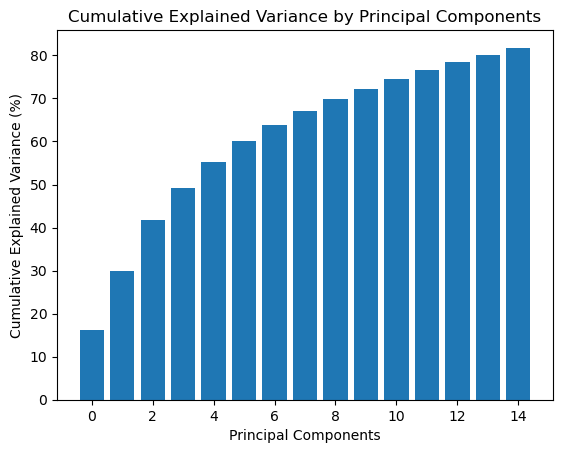

In [25]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0

while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k += 1

print(f"We reduced the number of features from 7,129 to just {k}, while still capturing approximately 90% of the total variance in the data.")


pca = PCA(n_components=k)

X_train_t.pca = pca.fit(X_train_t)
X_train_pca = pca.transform(X_train_t)
X_test_pca = pca.transform(X_test_t)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp)

plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")


In [19]:
y_train["patient"] = y_train["patient"].astype(str)
df_merged = pd.merge(y_train, X_train_t, left_on='patient', right_index=True)
df_merged.head()

,patient,cancer,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,1,ALL,-214,-153,-58,88,-295,-558,199,-176,...,185,511,-125,389,-37,793,329,36,191,-37
1,2,ALL,-139,-73,-1,283,-264,-400,-330,-168,...,169,837,-36,442,-17,782,295,11,76,-14
2,3,ALL,-76,-49,-307,309,-376,-650,33,-367,...,315,1199,33,168,52,1138,777,41,228,-41
3,4,ALL,-135,-114,265,12,-419,-585,158,-253,...,240,835,218,174,-110,627,170,-50,126,-91
4,5,ALL,-106,-125,-76,168,-230,-284,4,-122,...,156,649,57,504,-26,250,314,14,56,-25


Checking whether the normalized data has a mean of zero and a standard deviation of one.

In [45]:
np.mean(X_train_scaled),np.std(X_train_scaled)

(-9.27023234122341e-19, 1.0)

<Figure size 640x480 with 0 Axes>

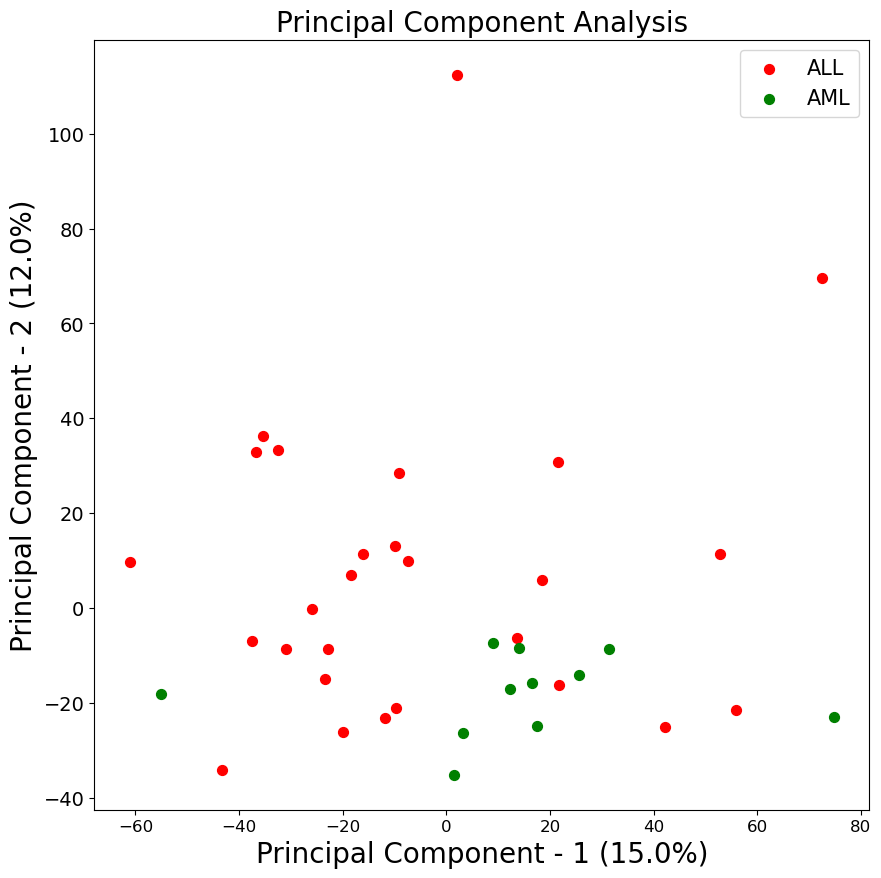

In [65]:
df_scaled  = pd.DataFrame(X_train_scaled, columns= X_train_t.columns)

pca = PCA(n_components=2)

pca_results = pca.fit_transform(df_scaled)

df_pca_results = pd.DataFrame(pca_results, columns=["PC1", "PC2"])

df_pca_results["Cancer"] = df_merged["cancer"].values


explained_var = pca.explained_variance_ratio_
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Principal Component - 1 ({pc1_var:.1f}%)',fontsize=20)
plt.ylabel(f'Principal Component - 2 ({pc2_var:.1f}%)',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
targets = df_pca_results["Cancer"].unique()
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca_results['Cancer'] == target
    plt.scatter(df_pca_results.loc[indicesToKeep, "PC1"]
               , df_pca_results.loc[indicesToKeep, "PC2"], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


## PCA Variance Explained

The first two principal components (PC1 and PC2) explain 15% and 12% of the total variance, respectively. While not dominant, they can still offer useful insights into the underlying data structure and class separation.

In [21]:

labels = {"ALL": 0, "AML": 1}

y_train["cancer"] = y_train["cancer"].map(labels)
y_test["cancer"] = y_test["cancer"].map(labels)


## Logistic Regression with Hyperparameter Tuning

We trained a logistic regression model to classify patients as having ALL or AML using their gene expression profiles. To optimize performance, we used GridSearchCV to perform a grid search over the regularization strength (C) and penalty type (l1 or l2), using 3-fold cross-validation and accuracy as the scoring metric.

The best model was selected based on cross-validation performance and then evaluated on the test set.

In [22]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 'penalty': ['l1', 'l2']}


log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(log_estimator, log_grid, cv=3, scoring='accuracy')

log_model.fit(X_train_scaled, y_train["cancer"])

best_log = log_model.best_estimator_

log_pred = best_log.predict(X_test_scaled)

log_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

## About the Hyperparameters

The parameter C controls the inverse of the regularization strength. Lower values of C imply stronger regularization, which can help prevent overfitting but may underfit the data if too strong.

The penalty term determines the type of regularization:
- l1 (Lasso) tends to produce sparse models, setting some coefficients to zero, which can be useful for feature selection.
- l2 (Ridge) distributes the penalty across all coefficients and generally performs better when all features are informative.

Using both options in the grid search allows the model to balance bias and variance effectively.

In [23]:
y_test["cancer"].value_counts()

0    20
1    14
Name: cancer, dtype: int64

In [24]:
print(f'Logistic Regression accuracy: {round(accuracy_score(y_test["cancer"], log_pred), 3)}')

Logistic Regression accuracy: 0.588


The logistic regression model achieved an accuracy of 0.588 on the test set. This means it correctly classified approximately 58.8% of the patients. While this is slightly better than random guessing in a binary classification problem, it suggests that the model may be underfitting or that the classes are not easily separable using linear decision boundaries alone. Further analysis, feature selection, or the use of more complex models may help improve performance.